In [1]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from collections import Counter
pd.set_option('display.max_columns', None)
from itertools import product
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score,KFold, cross_validate, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import statsmodels.api as sm
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, recall_score, precision_score, precision_recall_curve, roc_curve

C:\Users\ampad\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ampad\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\ampad\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [45]:
events = pd.read_csv('data_events.csv')
print(f"There are {events.shape[0]} rows and {events.shape[1]} columns")
print('Are there any missing values?',events.isnull().sum().any())
events.head()

There are 500000 rows and 3 columns
Are there any missing values? False


,user_pseudo_id,event_name,event_count
0,b77c070ea6bebab1b35869f2cea470bb,item_saved,58
1,48CA2D5DCC1B42F58C0C1CC0C82B3889,user_unfollowed,41
2,6d020ffe06aec17532a4ea558e370b8e,outfit_sent,59
3,FEF2FC6721994A659FA570B334FC2425,user_items_uploaded,46
4,693230A8ABE64D3A808F908A537E2985,sticker_uploaded,19


In [3]:
retention=pd.read_csv('data_retention.csv')
print(f"There are {retention.shape[0]} rows and {retention.shape[1]} columns")
print('Are there any missing values?',retention.isnull().sum().any())
retention.head()

There are 373296 rows and 2 columns
Are there any missing values? False


,user_pseudo_id,retentionScore
0,b77c070ea6bebab1b35869f2cea470bb,2.124394
1,48CA2D5DCC1B42F58C0C1CC0C82B3889,0.193921
2,6d020ffe06aec17532a4ea558e370b8e,0.004651
3,FEF2FC6721994A659FA570B334FC2425,0.138679
4,693230A8ABE64D3A808F908A537E2985,0.103337


In [47]:
#combine the two dataset
df=pd.merge(retention,events,how='left')
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns")
print('Are there any missing values?',df.isnull().sum().any())
df.head()

There are 500000 rows and 4 columns
Are there any missing values? False


,user_pseudo_id,retentionScore,event_name,event_count
0,b77c070ea6bebab1b35869f2cea470bb,2.124394,item_saved,58
1,b77c070ea6bebab1b35869f2cea470bb,2.124394,comment_posted,2
2,48CA2D5DCC1B42F58C0C1CC0C82B3889,0.193921,user_unfollowed,41
3,6d020ffe06aec17532a4ea558e370b8e,0.004651,outfit_sent,59
4,FEF2FC6721994A659FA570B334FC2425,0.138679,user_items_uploaded,46


### Basic descriptive analytics of the events

In [5]:
df.describe()

,retentionScore,event_count
count,500000.000000,500000.000000
mean,28.473917,65.781988
std,158.533778,499.469070
min,0.001000,1.000000
25%,0.072693,1.000000
50%,0.144214,2.000000
75%,1.192895,18.000000
max,20526.061321,80424.000000


#### There is a big standard deviation in both numerical columns, which signifies the values of both columns are far apart and spread out from the mean, which normally indicates outliers, but would leave it for now

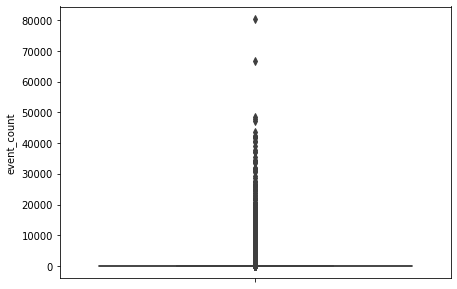

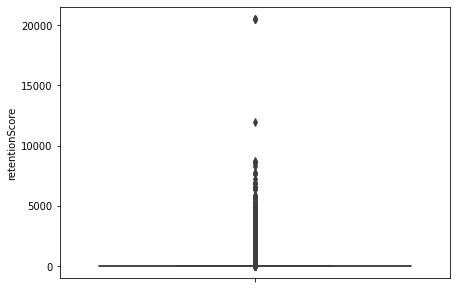

In [6]:
plt.figure(figsize=(7,17))
plt.subplot(3,1,1)
sns.boxplot(y=df['event_count'],data=df)

plt.figure(figsize=(7,17))
plt.subplot(3,1,1)
sns.boxplot(y=df['retentionScore'],data=df);

#### This boxplot gives further proof of the number of outliers present¶

C:\Users\ampad\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ampad\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


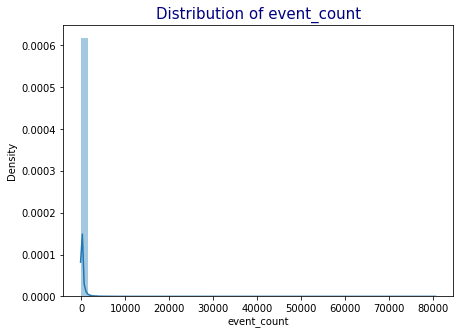

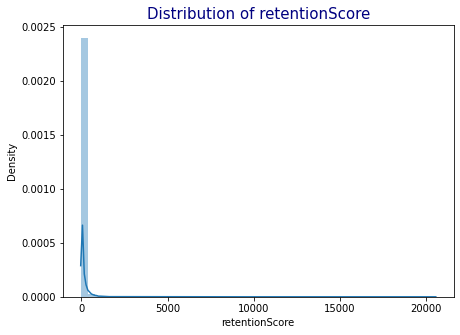

In [7]:
plt.figure(figsize=(7,17))
plt.subplot(3,1,1)
sns.distplot(df['event_count'])
plt.title('Distribution of event_count', color='navy', fontsize=15);

plt.figure(figsize=(7,17))
plt.subplot(3,1,1)
sns.distplot(df['retentionScore'])
plt.title('Distribution of retentionScore', color='navy', fontsize=15);

There were a total of 52 unique events that users performed
There are 373296 unique users


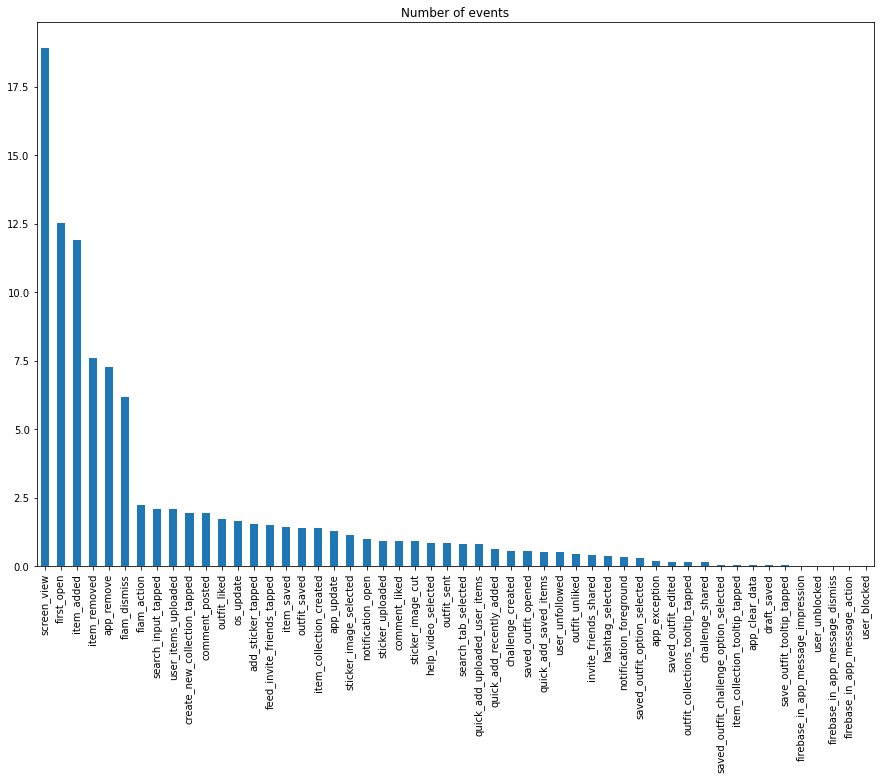

In [8]:
plt.figure(figsize=(15,10))
print(f"There were a total of {len(df['event_name'].value_counts())} unique events that users performed")
print(f"There are {len(df['user_pseudo_id'].unique())} unique users")
ax=((df['event_name'].value_counts()/len(df['event_name']))*100).plot(kind='bar')
ax.set_title('Number of events');

#### 1. There were a total of 52 unique events that users performed
#### 2.Just viewing the screen is the event that most users performed, which is obvious as that is the first thing everyone does
#### 3. 7.58% users removed the app, which should be a bit concerning, though there isnt much details to find out why, or how long between the time they downloaded and the time they deleted
#### 4. The least event that users performed was to block a user, with only 0.0004% of them doing that, which shows us that more often that not, the users relate well with each other
#### 5. Another thing is that, 18.89% users viewed the screen, but only 12.5% actually opened the app due to certain factors, which there isnt enough information here to tell. Also its possible the timeframe captured in this data wasnt long enough to determine if such users eventually opened the app

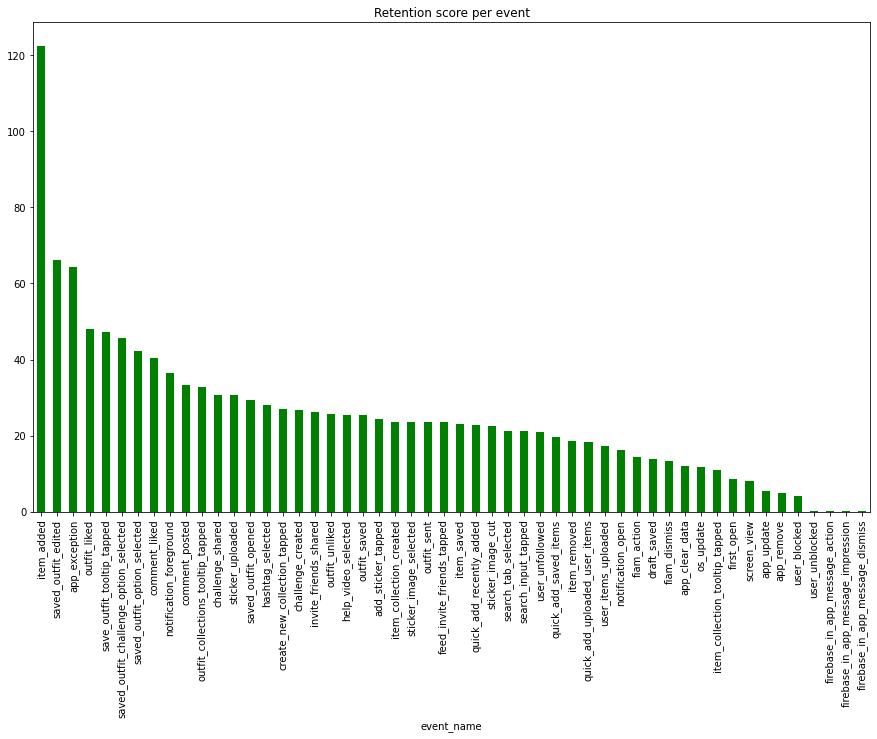

In [55]:
plt.figure(figsize=(15,9))
ax=df.groupby('event_name')['retentionScore'].mean().sort_values(ascending=False).plot(kind='bar',color='g')
ax.set_title('Retention score per event');

#### Users who keep adding items to their collection have the lowest probability of churning
#### Users who dismiss firebase in app messages are the most likely group of people to churn
#### Generally firebase related events have very low retenion scores

In [72]:
(len(df['user_pseudo_id'].value_counts().reset_index(name="count").query("count > 1")["index"]))/df['user_pseudo_id'].nunique()*100

25.960631777463462

#### Only over 25% of users performed more than one event, which suggests most users do not actually  perform a lot of actvity

                retentionScore  event_count
retentionScore        1.000000     0.173701
event_count           0.173701     1.000000


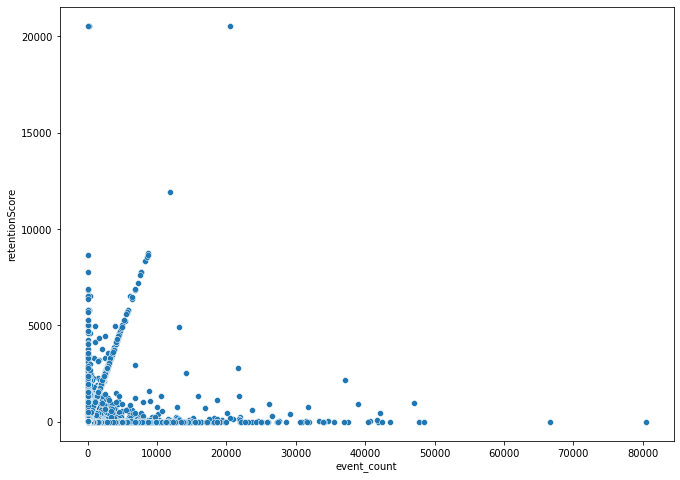

In [11]:
print(df.corr()) #only the numeric columns would be used
plt.figure(figsize=(11,8));
sns.scatterplot(x='event_count', y = 'retentionScore', data=df);

#### The number of events performed by users has a positive correlation with the retention score, though weak(0.1737), which suggests that the number of times a user performs an activity has an effect on whether they would eventually churn, the higher the events performed by users, the higher they would be keep using the combyne app

### Churn Prediction

In [12]:
df.head()

,user_pseudo_id,retentionScore,event_name,event_count
0,b77c070ea6bebab1b35869f2cea470bb,2.124394,item_saved,58
1,b77c070ea6bebab1b35869f2cea470bb,2.124394,comment_posted,2
2,48CA2D5DCC1B42F58C0C1CC0C82B3889,0.193921,user_unfollowed,41
3,6d020ffe06aec17532a4ea558e370b8e,0.004651,outfit_sent,59
4,FEF2FC6721994A659FA570B334FC2425,0.138679,user_items_uploaded,46


In [13]:
df['retentionScore'].describe()

count    500000.000000
mean         28.473917
std         158.533778
min           0.001000
25%           0.072693
50%           0.144214
75%           1.192895
max       20526.061321
Name: retentionScore, dtype: float64

In [14]:
#I would create a new feature called churned, where any retention score below the threshold(mean) would signify a churn and vice versa 
threshold = df['retentionScore'].mean() #threshold
df['churned']=pd.Series(np.where(df['retentionScore'].values >= threshold, 0, 1),df.index)
df.head()

,user_pseudo_id,retentionScore,event_name,event_count,churned
0,b77c070ea6bebab1b35869f2cea470bb,2.124394,item_saved,58,1
1,b77c070ea6bebab1b35869f2cea470bb,2.124394,comment_posted,2,1
2,48CA2D5DCC1B42F58C0C1CC0C82B3889,0.193921,user_unfollowed,41,1
3,6d020ffe06aec17532a4ea558e370b8e,0.004651,outfit_sent,59,1
4,FEF2FC6721994A659FA570B334FC2425,0.138679,user_items_uploaded,46,1


In [15]:
#normalize event count
df['event_count']=(df['event_count']-df['event_count'].min())/(df['event_count'].max()-df['event_count'].min())

In [16]:
#one hot enconde the categorical variable(event_name)
df=pd.get_dummies(df,columns=['event_name'])
print(df.shape)
df.head()

(500000, 56)


,user_pseudo_id,retentionScore,event_count,churned,event_name_add_sticker_tapped,event_name_app_clear_data,event_name_app_exception,event_name_app_remove,event_name_app_update,event_name_challenge_created,event_name_challenge_shared,event_name_comment_liked,event_name_comment_posted,event_name_create_new_collection_tapped,event_name_draft_saved,event_name_feed_invite_friends_tapped,event_name_fiam_action,event_name_fiam_dismiss,event_name_firebase_in_app_message_action,event_name_firebase_in_app_message_dismiss,event_name_firebase_in_app_message_impression,event_name_first_open,event_name_hashtag_selected,event_name_help_video_selected,event_name_invite_friends_shared,event_name_item_added,event_name_item_collection_created,event_name_item_collection_tooltip_tapped,event_name_item_removed,event_name_item_saved,event_name_notification_foreground,event_name_notification_open,event_name_os_update,event_name_outfit_collections_tooltip_tapped,event_name_outfit_liked,event_name_outfit_saved,event_name_outfit_sent,event_name_outfit_unliked,event_name_quick_add_recently_added,event_name_quick_add_saved_items,event_name_quick_add_uploaded_user_items,event_name_save_outfit_tooltip_tapped,event_name_saved_outfit_challenge_option_selected,event_name_saved_outfit_edited,event_name_saved_outfit_opened,event_name_saved_outfit_option_selected,event_name_screen_view,event_name_search_input_tapped,event_name_search_tab_selected,event_name_sticker_image_cut,event_name_sticker_image_selected,event_name_sticker_uploaded,event_name_user_blocked,event_name_user_items_uploaded,event_name_user_unblocked,event_name_user_unfollowed
0,b77c070ea6bebab1b35869f2cea470bb,2.124394,0.000709,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,b77c070ea6bebab1b35869f2cea470bb,2.124394,0.000012,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,48CA2D5DCC1B42F58C0C1CC0C82B3889,0.193921,0.000497,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,6d020ffe06aec17532a4ea558e370b8e,0.004651,0.000721,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,FEF2FC6721994A659FA570B334FC2425,0.138679,0.000560,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [17]:
df.head()

,user_pseudo_id,retentionScore,event_count,churned,event_name_add_sticker_tapped,event_name_app_clear_data,event_name_app_exception,event_name_app_remove,event_name_app_update,event_name_challenge_created,event_name_challenge_shared,event_name_comment_liked,event_name_comment_posted,event_name_create_new_collection_tapped,event_name_draft_saved,event_name_feed_invite_friends_tapped,event_name_fiam_action,event_name_fiam_dismiss,event_name_firebase_in_app_message_action,event_name_firebase_in_app_message_dismiss,event_name_firebase_in_app_message_impression,event_name_first_open,event_name_hashtag_selected,event_name_help_video_selected,event_name_invite_friends_shared,event_name_item_added,event_name_item_collection_created,event_name_item_collection_tooltip_tapped,event_name_item_removed,event_name_item_saved,event_name_notification_foreground,event_name_notification_open,event_name_os_update,event_name_outfit_collections_tooltip_tapped,event_name_outfit_liked,event_name_outfit_saved,event_name_outfit_sent,event_name_outfit_unliked,event_name_quick_add_recently_added,event_name_quick_add_saved_items,event_name_quick_add_uploaded_user_items,event_name_save_outfit_tooltip_tapped,event_name_saved_outfit_challenge_option_selected,event_name_saved_outfit_edited,event_name_saved_outfit_opened,event_name_saved_outfit_option_selected,event_name_screen_view,event_name_search_input_tapped,event_name_search_tab_selected,event_name_sticker_image_cut,event_name_sticker_image_selected,event_name_sticker_uploaded,event_name_user_blocked,event_name_user_items_uploaded,event_name_user_unblocked,event_name_user_unfollowed
0,b77c070ea6bebab1b35869f2cea470bb,2.124394,0.000709,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,b77c070ea6bebab1b35869f2cea470bb,2.124394,0.000012,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,48CA2D5DCC1B42F58C0C1CC0C82B3889,0.193921,0.000497,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,6d020ffe06aec17532a4ea558e370b8e,0.004651,0.000721,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,FEF2FC6721994A659FA570B334FC2425,0.138679,0.000560,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [18]:
X=df.drop(columns=['user_pseudo_id','retentionScore','churned'])
y=df['churned']

In [19]:
#check for imbalance in the target column
(y.value_counts()/len(y))*100

1    88.036
0    11.964
Name: churned, dtype: float64

In [20]:
#split into training and testing, and stratify using the target column
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.1, random_state=0, stratify=y)

In [38]:
print("The shape of X_train is:",X_train.shape)
print("The shape of X_test is:",X_test.shape)
print("The shape of y_train is:",y_train.shape)
print("The shape of y_test is:",y_test.shape)

The shape of X_train is: (450000, 53)
The shape of X_test is: (50000, 53)
The shape of y_train is: (450000,)
The shape of y_test is: (50000,)


#### The Logistic regression model, the random forest and the xgboost model are the classification models used to predict churn. 

#### Logistic regression chosen because it is excellent for binary classification, as in our case,     

#### The random forest is an ensemble model based on the concept of bagging, which has high predictive power, reduces overfitting and the feature importance of the various features that contribute to predictiing churn can be determined and 

#### Xgboost algorithm was chosen because it is also an ensemble model, and performs excellently in various conditions

### Model training using baseline default values

In [21]:
#Logistic Regression Model
logistic = LogisticRegression(solver='liblinear')
logistic.fit(X_train, y_train)
logistic_train_pred=logistic.predict(X_train)
logistic_test_pred=logistic.predict(X_test)
logistic_pred_proba = logistic.predict_proba(X_test)

#Random Forest
Rf = RandomForestClassifier()
Rf.fit(X_train, y_train)
Rf_train_pred=Rf.predict(X_train)
Rf_test_pred= Rf.predict(X_test)
Rf_pred_proba = Rf.predict_proba(X_test)

#XgBoost Model
xg = XGBClassifier()
xg.fit(X_train, y_train)
xg_train_pred=xg.predict(X_train)
xg_test_pred= xg.predict(X_test)
xg_pred_proba = xg.predict_proba(X_test)

### Evaluation metrics

#### For an unbalanced dataset, accuracy is a poor metric to use
#### Precision and recall are better evalutation metrics to be used
#### Precision refers to the number of positive class predictions that actually belong to the positive class, so upon the users that were predicted to churn, how many churned
#### Recall refers to the number of positive class predictions made out of all positive examples, so upon all the users that churned, how many did the model catch
#### Both are on either sides of the scale, a higher recall results in a lower precision, and vice versa
#### For a high recall, most of the relevant results would be captured regardless of whether or not irrelevant ones are also captured
#### For high precision, more relevant results would be captured than irrelevant ones
#### F1 score is the harmonic mean between the recall and precision, and here, the model with the highest f1 score would be used for further analysis, since it is a balance or tradeoff between the precision and recall
#### The emphasis here would be on the users that churned

In [22]:
#Logistic Regression Model
print('___________________________________________')
print('Logistic Regression')
print('___________________________________________')
print('Model performance for Training set')
print('- Accuracy: %s' % accuracy_score(y_train,logistic_train_pred))
print('- F1 score: %s' % f1_score(y_train,logistic_train_pred))
print('- Precision score: %s' % precision_score(y_train,logistic_train_pred))
print('- Recall score: %s' % recall_score(y_train,logistic_train_pred))
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % accuracy_score(y_test,logistic_test_pred))
print('- F1 score: %s' % f1_score(y_test,logistic_test_pred))
print('- Precision score: %s' % precision_score(y_test,logistic_test_pred))
print('- Recall score: %s' % recall_score(y_test,logistic_test_pred))

print('___________________________________________')
print("Random Forest")
print('___________________________________________')
print('Model performance for Training set')
print('- Accuracy: %s' % accuracy_score(y_train,Rf_train_pred))
print('- F1 score: %s' % f1_score(y_train,Rf_train_pred))
print('- Precision score: %s' % precision_score(y_train,Rf_train_pred))
print('- Recall score: %s' % recall_score(y_train,Rf_train_pred))
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % accuracy_score(y_test,Rf_test_pred))
print('- F1 score: %s' % f1_score(y_test,Rf_test_pred))
print('- Precision score: %s' % precision_score(y_test,Rf_test_pred))
print('- Recall score: %s' % recall_score(y_test,Rf_test_pred))

print('___________________________________________')
print('XGBoost')
print('___________________________________________')
print('Model performance for Training set')
print('- Accuracy: %s' % accuracy_score(y_train,xg_train_pred))
print('- F1 score: %s' % f1_score(y_train,xg_train_pred))
print('- Precision score: %s' % precision_score(y_train,xg_train_pred))
print('- Recall score: %s' % recall_score(y_train,xg_train_pred))
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % accuracy_score(y_test,xg_test_pred))
print('- F1 score: %s' % f1_score(y_test,xg_test_pred))
print('- Precision score: %s' % precision_score(y_test,xg_test_pred))
print('- Recall score: %s' % recall_score(y_test,xg_test_pred))

___________________________________________
Logistic Regression
___________________________________________
Model performance for Training set
- Accuracy: 0.8917955555555556
- F1 score: 0.9385616263781743
- Precision score: 0.9383129989000232
- Recall score: 0.9388103856503147
----------------------------------
Model performance for Test set
- Accuracy: 0.89064
- F1 score: 0.9378622241414578
- Precision score: 0.9382673942701227
- Recall score: 0.9374574037893589
___________________________________________
Random Forest
___________________________________________
Model performance for Training set
- Accuracy: 0.9510933333333333
- F1 score: 0.9729695871008629
- Precision score: 0.9475183717992881
- Recall score: 0.9998258288276008
----------------------------------
Model performance for Test set
- Accuracy: 0.94868
- F1 score: 0.9716307352128248
- Precision score: 0.9463731909028257
- Recall score: 0.9982734335953474
___________________________________________
XGBoost
__________________

In [23]:
f1_test_list = {'Logistic regression':f1_score(y_test,logistic_test_pred),
'random_forest': f1_score(y_test,Rf_test_pred),
'xg_boost': f1_score(y_test,xg_test_pred),
}
f1_df = pd.DataFrame.from_dict(f1_test_list, orient='index', columns=['F1'],)
f1_df.sort_values(by='F1',ascending=False)

,F1
xg_boost,0.972322
random_forest,0.971631
Logistic regression,0.937862


#### The xgboost f1 score was the highest, so would be used for further analysis

Model performance for Test set
- AUC score: 0.7905382815112003
- F1 score: 0.9723222371937885
- Precision score: 0.9461353280027512
- Recall score: 1.0


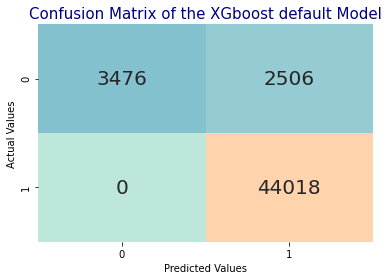

In [24]:
print('Model performance for Test set')
print('- AUC score: %s' % roc_auc_score(y_test,xg_test_pred))
print('- F1 score: %s' % f1_score(y_test,xg_test_pred))
print('- Precision score: %s' % precision_score(y_test,xg_test_pred))
print('- Recall score: %s' % recall_score(y_test,xg_test_pred))

sns.heatmap(confusion_matrix(y_test, xg_test_pred),annot=True, annot_kws={"fontsize":20}, fmt='d', cbar=False,cmap='icefire')
plt.title('Confusion Matrix of the XGboost default Model', color='navy', fontsize=15)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values');

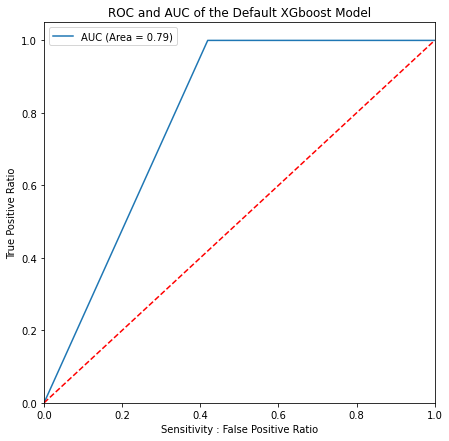

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, xg_test_pred)
plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, label='AUC (Area = %0.2f)' %roc_auc_score(y_test,xg_test_pred))
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Sensitivity : False Positive Ratio')
plt.ylabel('True Positive Ratio')
plt.title('ROC and AUC of the Default XGboost Model')
plt.legend()
plt.show()

#### With the default model(threshold at 0.5), all customers that churned were predicted to have churned, there were no false negatives, so the model does excellently in this regard, hence the 100% recall
#### The model predicted 2506 customers as having churned, when they did not churn, so here, combyne would have to spend money and resources on the 2506 users to get them to not churn, for example more personalized advertissment, more incentives and the likes
#### With this mind, i would like the model to be more precise in predicting churn, to reduce the number of misclassified customers that did not churn, but were predicted to have churned, by increasing the threshold considerably to 0.8 and 0.9

In [26]:
# Xgboost predictions with threshold at 0.8:
xg_pred_8 = xg.predict_proba(X_test)[:,1] >= 0.8

# Xgboost predictions with threshold at 09:
xg_pred_9 = xg.predict_proba(X_test)[:,1] >= 0.9

In [27]:
print('---------------------------------------------------')
print('Model performance for Default Xgboost model')
print('---------------------------------------------------')
print('- AUC score: %s' % roc_auc_score(y_test,xg_test_pred))
print('- F1 score: %s' % f1_score(y_test,xg_test_pred))
print('- Precision score: %s' % precision_score(y_test,xg_test_pred))
print('- Recall score: %s' % recall_score(y_test,xg_test_pred))

print('---------------------------------------------------')
print('Model performance for Xgboost model with threshold at 0.8')
print('---------------------------------------------------')
print('- AUC score: %s' % roc_auc_score(y_test,xg_pred_8))
print('- F1 score: %s' % f1_score(y_test,xg_pred_8))
print('- Precision score: %s' % precision_score(y_test,xg_pred_8))
print('- Recall score: %s' % recall_score(y_test,xg_pred_8))

print('---------------------------------------------------')
print('Model performance for Xgboost model with threshold at 0.9')
print('---------------------------------------------------')
print('- AUC score: %s' % roc_auc_score(y_test,xg_pred_9))
print('- F1 score: %s' % f1_score(y_test,xg_pred_9))
print('- Precision score: %s' % precision_score(y_test,xg_pred_9))
print('- Recall score: %s' % recall_score(y_test,xg_pred_9))

---------------------------------------------------
Model performance for Default Xgboost model
---------------------------------------------------
- AUC score: 0.7905382815112003
- F1 score: 0.9723222371937885
- Precision score: 0.9461353280027512
- Recall score: 1.0
---------------------------------------------------
Model performance for Xgboost model with threshold at 0.8
---------------------------------------------------
- AUC score: 0.7918972397222565
- F1 score: 0.9698870626309198
- Precision score: 0.9468934623125366
- Recall score: 0.9940251715207415
---------------------------------------------------
Model performance for Xgboost model with threshold at 0.9
---------------------------------------------------
- AUC score: 0.7918246158652552
- F1 score: 0.9551109806489488
- Precision score: 0.9493446449411976
- Recall score: 0.9609477940842382


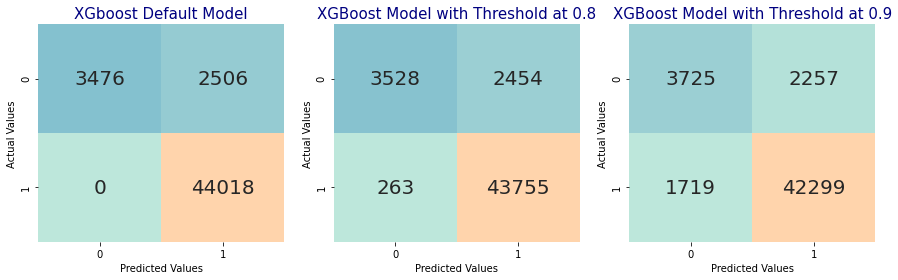

In [28]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
sns.heatmap(confusion_matrix(y_test, xg_test_pred), annot=True, annot_kws={"fontsize":20}, fmt='d', cbar=False, cmap='icefire')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('XGboost Default Model', color='navy', fontsize=15)

plt.subplot(1,3,2)
sns.heatmap(confusion_matrix(y_test, xg_pred_8), annot=True, annot_kws={"fontsize":20}, fmt='d', cbar=False, cmap='icefire')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('XGBoost Model with Threshold at 0.8', color='navy', fontsize=15)

plt.subplot(1,3,3)
sns.heatmap(confusion_matrix(y_test, xg_pred_9), annot=True, annot_kws={"fontsize":20}, fmt='d', cbar=False, cmap='icefire')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('XGBoost Model with Threshold at 0.9', color='navy', fontsize=15);

#### Increasing the threshold to 0.8, would make combyne lose 263 users instead of not losing any user at all, but it would save more money on giving incentives and offers, since now the users who were predicted to have churned when they did not, has reduced, hence the precision increasing, at the expense of the recall

#### Increasing the threshold to 0.9, would further misclassify more users as not churning, when indeed they did, and reducing the users that did not churn, but predicted as churn. Combyne would lose 1719 users with this model, but would send out personalized ads and offers to only 2257 users, instead of the 2506 with the default model and 2454 with the model at 0.8 threshold


## For decision making

#### To make informed decisions to stakeholders, if combyne believes losing users is more expensive than sending out incentives and offers to users, the model with default threshold should be used, as that one captures all users that churned
#### If combyne thinks losing users and sending out incentives and offers is equally important, the model with threshold at 0.8 should be used, as that one reduces the occurence of false positives a bit, whiles leaving room for a bit of false negatives
#### If combyne thinks sending out incentives and offers is more important losing users, the model with threshold at 0.9 should be used, as that one greatly reduces the occurence of false positives(predicting users churned, when they did not) at the expense of false negatives
#### Any of these models can be chosen for decision making, depending on what combyne thinks is the least expensive route to take

### Some of the shortcomings include:¶
#### 1.The model doesnt do a very good in predicting users that did not churn, with a lot of mistakes being made in predicting them as having churned, hence the model has a high false negative rate
#### 2.In creating the churned features from the retention score feature, i did not have enough information to create an accurate target variable, so i used the mean as the threshold
#### 3.The data used is no where enough to build robust models
#### 4.No hyperparameter tuning done on the models to improve performances
#### 5.Little feature engineering done

## Statistical model explaining churn in terms of the explanatory variables and provide interpretations of coefficients and standard errors in these models

In [29]:
logit_model=sm.Logit(X_train,y_train)
result=logit_model.fit(method='lbfgs',maxiter=500)
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                churned   No. Observations:               450000
Model:                          Logit   Df Residuals:                   449947
Method:                           MLE   Df Model:                           52
Date:                Fri, 24 Sep 2021   Pseudo R-squ.:                  0.2471
Time:                        08:54:53   Log-Likelihood:            -1.2407e+05
converged:                       True   LL-Null:                   -1.6479e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
event_count                                         -45.4486      1.124    -40.444      0.000     -47.651     -43.246
event_name_add

#### The model was fitted using the maximum likelihood estimation technique, and it converged, after increasing max iteration to 500
#### The statistical test shows that when the model is fitted with only intercept then the log-likelihood = -164790 which shows improvement when fitted with all independent variables Log-Likelihood = -124070. Fit improvement is also significant (p-value <0.05, though it was exactly 0).
#### Regarding the coefficient tables, only firebase_in_app_message_action,firebase_in_app_message_dismiss,firebase_in_app_message_impression,user_unblocked and user_blocked did not have signifant influence (pvalues < 0.05) on churn
#### One thing to note is that, the coefficients here are in log-odd terms, so they would be converted to odds ratios for better intuivtive explanation 
#### The standard error refers to the average distance that the observed values fall from the regression line. This tells you how wrong the model is on average using the units of the response variable. Smaller values are better because it indicates that the observations are closer to the fitted line.
#### The app_clear_data column has a standard error of 0.359, which indicates it is only 0.359 from the fitted line, and the event_name_firebase_in_app_message_action has a standard error of 1.755, which means it is 1.755 from the fitted line, as indicated earlier, the closer it is to the fitted line, the better

In [30]:
print(np.exp(result.params))

event_count                                          1.827832e-20
event_name_add_sticker_tapped                        1.033908e+01
event_name_app_clear_data                            1.712235e+01
event_name_app_exception                             7.562132e+00
event_name_app_remove                                4.187015e+01
event_name_app_update                                2.870380e+01
event_name_challenge_created                         9.924288e+00
event_name_challenge_shared                          7.512925e+00
event_name_comment_liked                             5.184943e+00
event_name_comment_posted                            6.171535e+00
event_name_create_new_collection_tapped              1.093535e+01
event_name_draft_saved                               1.091890e+01
event_name_feed_invite_friends_tapped                1.110217e+01
event_name_fiam_action                               1.643928e+01
event_name_fiam_dismiss                              1.709510e+01
event_name

#### The log-odds can be converted to odds ratio, which makes more sense in interpreting, odds ratio is simply the ratio of one event occuring, to that event not ocuring, this can be derived by taking the exponents of the coefficients
#### Using the app_update feature again, it can be observed that app_update has an Odds Ratio of 28.70 which is  significant in predicitng churn,  indicates that odds of  churning are 28.70 times higher for a user performing an app_update than a user not performing the update, and the odds of churning are 6.17 times higher for a user posting a comment than a user not posting a comment, which is also significant